## Import everything:
Ignore the complaints that wget and/or Poppy are not installed.

In [1]:
import simmetis as sim
from astropy import units as u
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load the input and config files to create a simulator instance.
Adjust the paths to point to the files on your system.
Also make sure that the config file contains the correct SIM_DATA_DIR.

In [2]:
lms = sim.spectro.LMS("../test_data/LINE_3D_013.fits", "metis_spectro_LMS.config")

Source file  ../test_data/LINE_3D_013.fits
201 x 201 pixels, 251 spectral channels
BUNIT: JY/PIXEL
Reading config metis_spectro_LMS.config


## Simulate what happens to the data cube on the way through the atmosphere, the telescope, and METIS:
The arguments are:
1. the atmospheric conditions - "best", "median", or "poor"
2. The PSF to use.  Any PSF from http://www.mpia.de/homes/feldt/METIS_AO/table.html should work.
3. The total exposure time in seconds.
4. The number of DITs

This can take a few minutes, depending on your computer.



--------------------Transmission and Emission--------------------


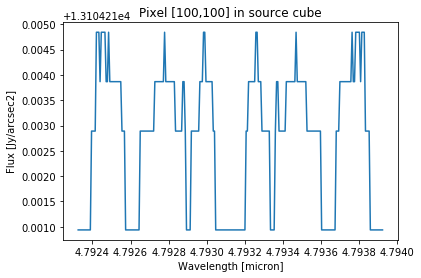

Reading  ../data/skycal_R308296_best_conditions.fits


/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/simmetis/psf.py:1201: UserWarning: CDELT > 1. Assuming the scale to be [mas]
  warnings.warn("CDELT > 1. Assuming the scale to be [mas]")
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


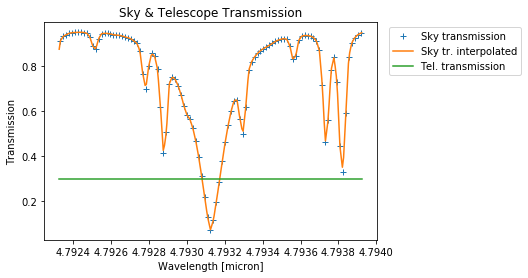

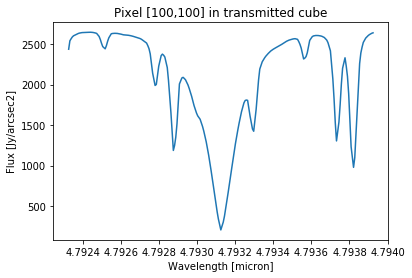

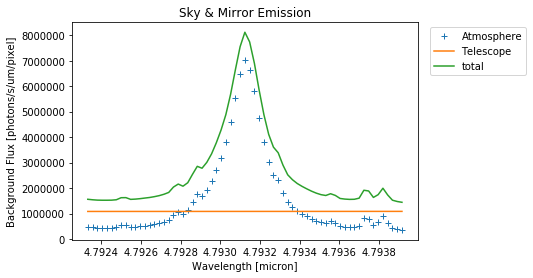


--------------------Convolution with PSF--------------------
image pixscale from WCS: [ 4.01736511  4.01736511] mas / pixel
Reading PSF ../data/PSF_SCAO_9mag_06seeing.fits
Convolving with PSF...


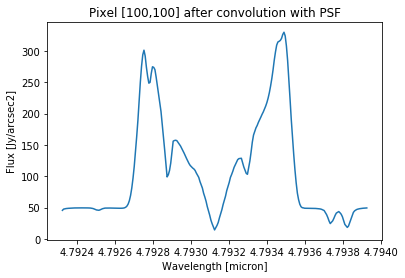


--------------------Convolution with LSF--------------------


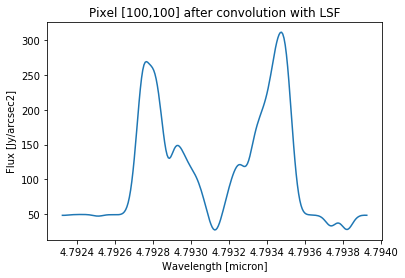


--------------------Scale to detector pixels--------------------
Source peak: 1691.8458996401441 electron / s
Background:  138.6911523225454 electron / s


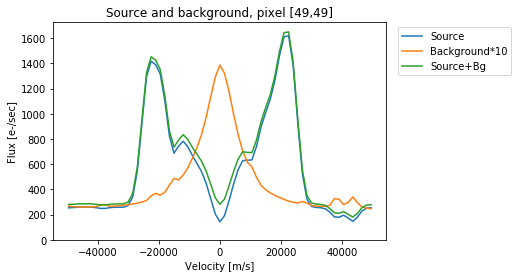

Exptime 60.0 s, NDIT = 2 , using DIT 30.0 s
Peak in one DIT 51718.07361436195 electron


In [3]:
result = lms.simulate('best', "PSF_SCAO_9mag_06seeing.fits", 60., 2, plot=True)

#### The result is an HDU object, i.e. you can write it to a FITS file, or access its data and header:

In [4]:
result.writeto("Test_output.fits", overwrite=True)
cube = result.data
print(cube.shape)
print(result.header['HIERARCH SCOPE_TEMPERATURE'])

(67, 99, 99)
-15.0


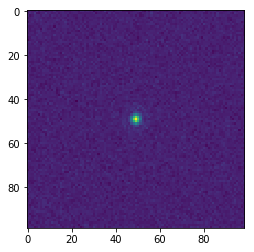

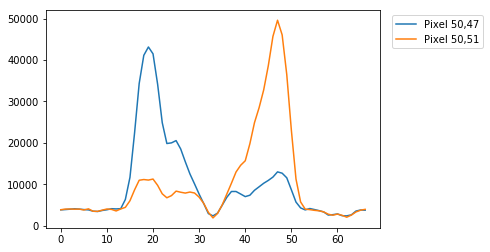

In [5]:
plt.figure()
plt.imshow(cube[33,:,:])

plt.figure()
plt.plot(cube[:,50,47], label="Pixel 50,47")
plt.plot(cube[:,50,51], label="Pixel 50,51")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))

## The last simulation step can be repeated with a different integration time:
By default, the total integration time and number of DITs are taken from the config file.

If you're curious, you can also write out the raw data cubes containing source+background and/or the background (the final result is the difference of these two data cubes).

In [6]:
result = lms.compute_snr(exptime=600., ndit=20, 
                         write_src_w_bg="Source+Background.fits",
                         write_background="Background.fits")

Source peak: 1691.8458996401441 electron / s
Background:  138.6911523225454 electron / s
Exptime 600.0 s, NDIT = 20 , using DIT 30.0 s
Peak in one DIT 51718.07361436195 electron
Writing source+background to " Source+Background.fits "
Writing background to " Background.fits "


600.0


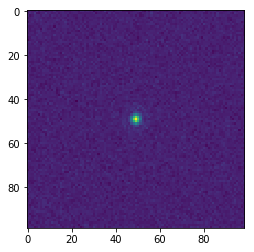

In [7]:
print(result.header['HIERARCH OBS_EXPTIME'])

plt.figure()
plt.imshow(cube[33,:,:])

## To calibrate the flux, feed the result to the calibrate_flux()-function:

Jy/arcsec2


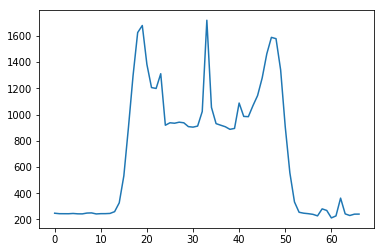

In [8]:
result = lms.calibrate_flux(result)
print(result.header['BUNIT'])
plt.plot(result.data[:,49,49])

## You can also run the steps of the simulation individually:
This gives you a bit more control over the plots created.

The function save_cube() can be used to save the data cube after each intermediate step to a FITS file. (Note that the final data cube is returned, but not stored internally. Therefore, save_cube cannot save the final result. Use result.writeto() instead.)

#### Do not skip any of the steps or change the order!!!


--------------------Transmission and Emission--------------------


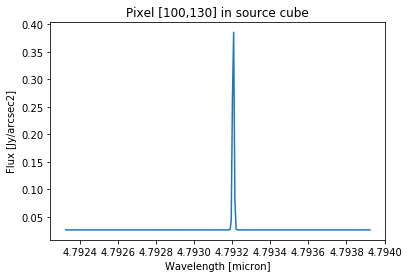

Reading  ../data/skycal_R308296_best_conditions.fits


/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/simmetis/psf.py:1201: UserWarning: CDELT > 1. Assuming the scale to be [mas]
  warnings.warn("CDELT > 1. Assuming the scale to be [mas]")
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


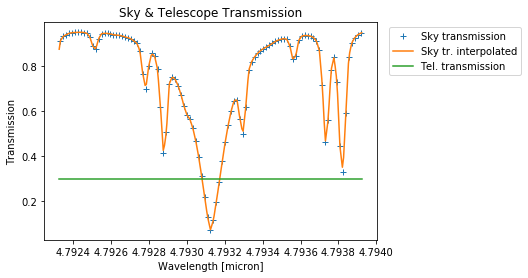

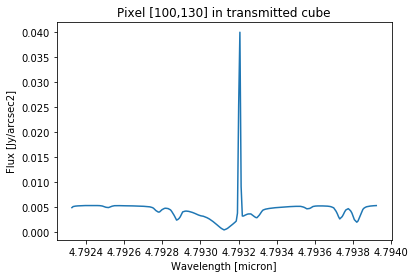

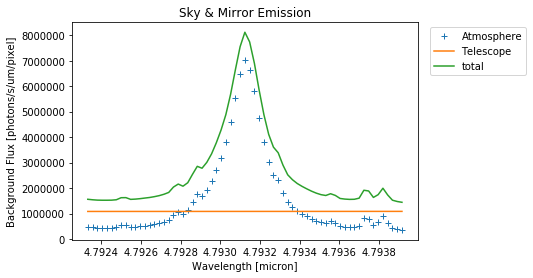

Writing data cube to datacube_transmitted.fits

--------------------Convolution with PSF--------------------
image pixscale from WCS: [ 4.01736511  4.01736511] mas / pixel
Reading PSF ../data/PSF_SCAO_9mag_06seeing.fits
Convolving with PSF...
Writing data cube to datacube_convolved_with_psf.fits

--------------------Convolution with LSF--------------------


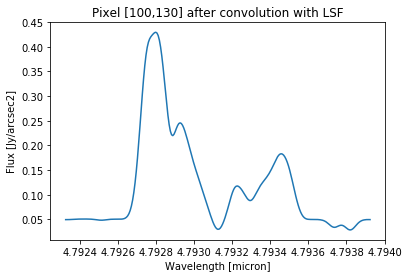

Writing data cube to datacube_convolved_with_lsf.fits

--------------------Scale to detector pixels--------------------


In [ ]:
lms.plotpix = np.asarray((100,130))   # set the pixel shown in the plots

lms.transmission_emission(conditions='best', plot=True)
lms.save_cube("datacube_transmitted.fits")

lms.convolve_psf("PSF_SCAO_9mag_06seeing.fits", plot=False)
lms.save_cube("datacube_convolved_with_psf.fits")

lms.convolve_lsf(plot=True)
lms.save_cube("datacube_convolved_with_lsf.fits")

lms.scale_to_detector()
lms.save_cube("datacube_scaled_to_detector.fits")

result = lms.compute_snr(exptime=600, ndit=12, plot=True)
result.writeto("datacube_final_12x50s.fits", overwrite=True)

600
50.0
12


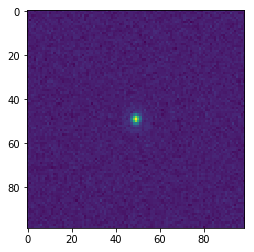

In [16]:
print(result.header['EXPTIME'])
print(result.header['DIT'])
print(result.header['NDIT'])

plt.figure()
plt.imshow(cube[33,:,:])